In [8]:
%load_ext autoreload
%autoreload 2
import pycolmap
from pathlib import Path
import sys
sys.path.append("ext_deps/Hierarchical-Localization")
from imc2023.utils.utils import create_submission, get_data_from_dir, setup_logger
from imc2023.utils.eval import eval
from collections import defaultdict
from hloc.utils.io import list_h5_names
from hloc import localize_sfm, visualization
import os
import numpy as np

setup_logger()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
dataset, scene = 'heritage', 'dioscuri'
data_dir = Path('image-matching-challenge-2023')
experiment_dir = Path(f'outputs/DISK+SP+LG/{dataset}/{scene}')
sfm_path = experiment_dir / 'sparse'
features = experiment_dir / 'features.h5'
matches = experiment_dir / 'matches.h5'
pairs = experiment_dir / 'pairs.txt'

image_dir = data_dir / 'train' / dataset / scene / 'images'
reconstruction = pycolmap.Reconstruction(sfm_path)
print(reconstruction.summary())

data_dict = get_data_from_dir(data_dir, 'train')

img_list = list_h5_names(features)

# img_list = [x.replace(f'{dataset}/{scene}/', '') for x in data_dict[dataset][scene]]
reg_image_names = [im.name for imid, im in reconstruction.images.items()]

missing = list(set(img_list) - set(reg_image_names))
queries = [(x, pycolmap.infer_camera_from_image(image_dir / x)) for x in missing]

INFO:root:================================================================================
[2023/05/28 00:33:11 root INFO] ================================================================================
INFO:root:DATA:
[2023/05/28 00:33:11 root INFO] DATA:
INFO:root:================================================================================
[2023/05/28 00:33:11 root INFO] ================================================================================
INFO:root:urban
[2023/05/28 00:33:11 root INFO] urban
INFO:root:  kyiv-puppet-theater: 27 imgs
[2023/05/28 00:33:11 root INFO]   kyiv-puppet-theater: 27 imgs
INFO:root:heritage
[2023/05/28 00:33:11 root INFO] heritage
INFO:root:  cyprus: 30 imgs
[2023/05/28 00:33:11 root INFO]   cyprus: 30 imgs
INFO:root:  dioscuri: 174 imgs
[2023/05/28 00:33:11 root INFO]   dioscuri: 174 imgs
INFO:root:  wall: 43 imgs
[2023/05/28 00:33:11 root INFO]   wall: 43 imgs
INFO:root:haiper
[2023/05/28 00:33:11 root INFO] haiper
INFO:root:  bike: 15 imgs
[2

Reconstruction:
	num_reg_images = 143
	num_cameras = 143
	num_points3D = 97860
	num_observations = 512893
	mean_track_length = 5.24109
	mean_observations_per_image = 3586.66
	mean_reprojection_error = 0.821904


In [26]:
results = defaultdict(lambda: defaultdict(dict))
for _, im in reconstruction.images.items():
    img_name = os.path.join(dataset, scene, "images", im.name)
    # problem: tvec is a reference! --> force copy
    results[dataset][scene][img_name] = {"R": im.rotmat(), "t": np.array(im.tvec)}
create_submission(results, data_dict, 'submission.csv')
eval(submission_csv='submission.csv', data_dir=data_dir, verbose=True)

INFO:root:Written 143 of 328 images to submission file.
[2023/05/28 00:33:13 root INFO] Written 143 of 328 images to submission file.
INFO:root:*** METRICS ***
[2023/05/28 00:33:13 root INFO] *** METRICS ***
INFO:root:urban / kyiv-puppet-theater (26 images, 325 pairs) -> mAA=0.000000, mAA_q=0.010154, mAA_t=0.036615
[2023/05/28 00:33:13 root INFO] urban / kyiv-puppet-theater (26 images, 325 pairs) -> mAA=0.000000, mAA_q=0.010154, mAA_t=0.036615
INFO:root:urban -> mAA=0.000000
[2023/05/28 00:33:13 root INFO] urban -> mAA=0.000000
INFO:root:heritage / dioscuri (174 images, 15051 pairs) -> mAA=0.574792, mAA_q=0.669304, mAA_t=0.581735
[2023/05/28 00:33:15 root INFO] heritage / dioscuri (174 images, 15051 pairs) -> mAA=0.574792, mAA_q=0.669304, mAA_t=0.581735
INFO:root:heritage / cyprus (30 images, 435 pairs) -> mAA=0.000000, mAA_q=0.000460, mAA_t=0.003218
[2023/05/28 00:33:15 root INFO] heritage / cyprus (30 images, 435 pairs) -> mAA=0.000000, mAA_q=0.000460, mAA_t=0.003218
INFO:root:herita

0.06387813

In [38]:
logs = localize_sfm.main(
    reconstruction,
    queries,
    pairs,
    features,
    matches,
    experiment_dir / 'loc.txt',
    covisibility_clustering=True)  # not required with SuperPoint+SuperGlue



[2023/05/28 00:46:43 hloc INFO] Reading the 3D model...
[2023/05/28 00:46:43 hloc INFO] Starting localization...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:22<00:00,  2.67s/it]
[2023/05/28 00:48:05 hloc INFO] Localized 31 / 31 images.
[2023/05/28 00:48:05 hloc INFO] Writing poses to outputs/DISK+SP+LG/heritage/dioscuri/loc.txt...
[2023/05/28 00:48:05 hloc INFO] Writing logs to outputs/DISK+SP+LG/heritage/dioscuri/loc.txt_logs.pkl...
[2023/05/28 00:48:05 hloc INFO] Done!


In [45]:
results = defaultdict(lambda: defaultdict(dict))
for q, v in logs['loc'].items():
    v = v['log_clusters'][v['best_cluster']]
    print(q, v['PnP_ret']['num_inliers'], np.mean(list(v['PnP_ret']['inliers'])), len(v['db']))
    im = pycolmap.Image(q, tvec=v['PnP_ret']['tvec'], qvec=v['PnP_ret']['qvec'])
#     print(im.tvec, im.qvec)
    img_name = os.path.join(dataset, scene, "images", q)
    results[dataset][scene][img_name] = {"R": im.rotmat(), "t": np.array(im.tvec)}
create_submission(results, data_dict, 'submission.csv')
eval(submission_csv='submission.csv', data_dir=data_dir, verbose=True)

INFO:root:Written 31 of 328 images to submission file.
[2023/05/28 00:50:52 root INFO] Written 31 of 328 images to submission file.
INFO:root:*** METRICS ***
[2023/05/28 00:50:52 root INFO] *** METRICS ***
INFO:root:urban / kyiv-puppet-theater (26 images, 325 pairs) -> mAA=0.000000, mAA_q=0.010154, mAA_t=0.036615
[2023/05/28 00:50:52 root INFO] urban / kyiv-puppet-theater (26 images, 325 pairs) -> mAA=0.000000, mAA_q=0.010154, mAA_t=0.036615
INFO:root:urban -> mAA=0.000000
[2023/05/28 00:50:52 root INFO] urban -> mAA=0.000000


archive_0160.png 8 0.022988505747126436 27
archive_0034.png 8 0.02631578947368421 30
archive_0092.png 8 0.028268551236749116 30
archive_0064.png 8 0.03225806451612903 26
archive_0022.png 12 0.0425531914893617 26
3DOM_FBK_IMG_1561.png 82 0.07186678352322524 56
archive_0032.png 8 0.0446927374301676 26
archive_0072.png 14 0.0603448275862069 27
3DOM_FBK_IMG_1577.png 11 0.012035010940919038 47
archive_0132.png 11 0.017741935483870968 43
archive_0063.png 8 0.028070175438596492 25
3DOM_FBK_IMG_1583.png 21 0.022483940042826552 47
archive_0036.png 8 0.032520325203252036 29
archive_0024.png 8 0.03902439024390244 26
archive_0030.png 8 0.020833333333333332 36
archive_0029.png 7 0.02834008097165992 25
archive_0156.png 12 0.03669724770642202 31
archive_0028.png 10 0.03048780487804878 30
archive_0071.png 8 0.025157232704402517 29
archive_0066.png 8 0.027303754266211604 31
archive_0055.png 11 0.03503184713375796 27
archive_0095.png 9 0.016605166051660517 39
archive_0062.png 10 0.03558718861209965 28
a

INFO:root:heritage / dioscuri (174 images, 15051 pairs) -> mAA=0.001628, mAA_q=0.003402, mAA_t=0.016617
[2023/05/28 00:50:54 root INFO] heritage / dioscuri (174 images, 15051 pairs) -> mAA=0.001628, mAA_q=0.003402, mAA_t=0.016617
INFO:root:heritage / cyprus (30 images, 435 pairs) -> mAA=0.000000, mAA_q=0.000460, mAA_t=0.003218
[2023/05/28 00:50:54 root INFO] heritage / cyprus (30 images, 435 pairs) -> mAA=0.000000, mAA_q=0.000460, mAA_t=0.003218
INFO:root:heritage / wall (43 images, 903 pairs) -> mAA=0.000111, mAA_q=0.682281, mAA_t=0.000111
[2023/05/28 00:50:54 root INFO] heritage / wall (43 images, 903 pairs) -> mAA=0.000111, mAA_q=0.682281, mAA_t=0.000111
INFO:root:heritage -> mAA=0.000580
[2023/05/28 00:50:54 root INFO] heritage -> mAA=0.000580
INFO:root:haiper / bike (15 images, 105 pairs) -> mAA=0.000000, mAA_q=0.000000, mAA_t=0.000000
[2023/05/28 00:50:54 root INFO] haiper / bike (15 images, 105 pairs) -> mAA=0.000000, mAA_q=0.000000, mAA_t=0.000000
INFO:root:haiper / chairs (16 

0.00019317119

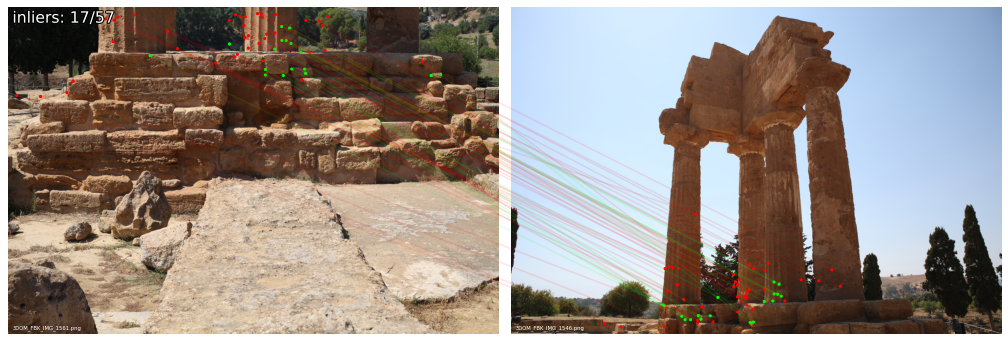

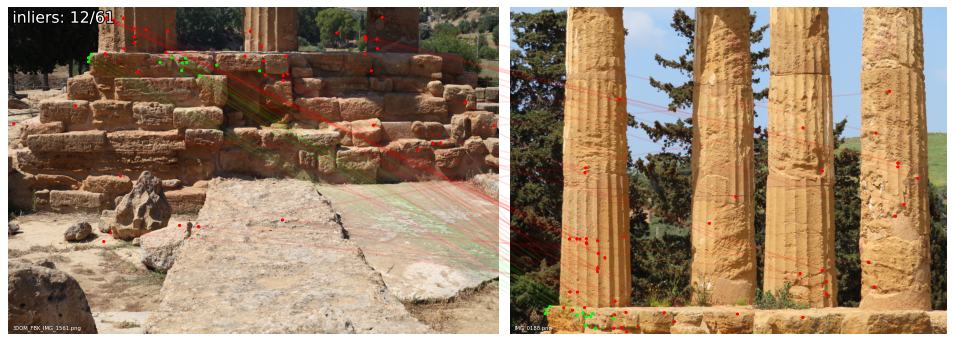

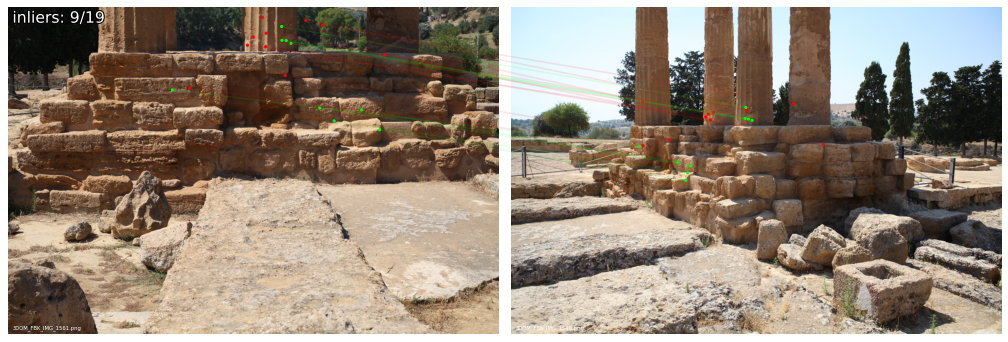

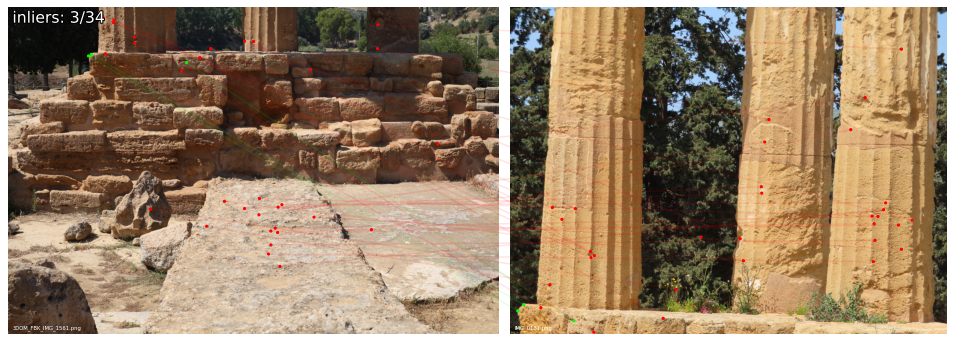

In [40]:
visualization.visualize_loc(
    experiment_dir / 'loc.txt', image_dir, reconstruction, n=2, top_k_db=5, seed=10, selected=['3DOM_FBK_IMG_1561.png'])

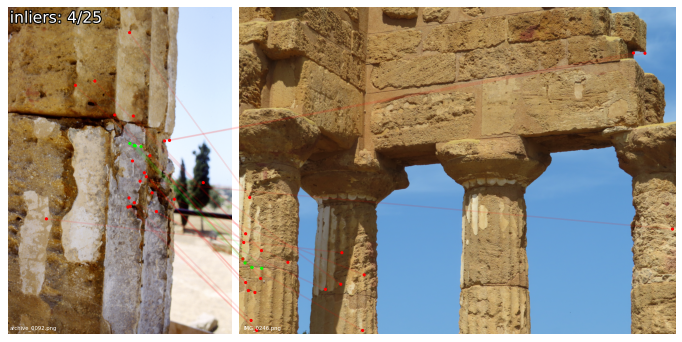

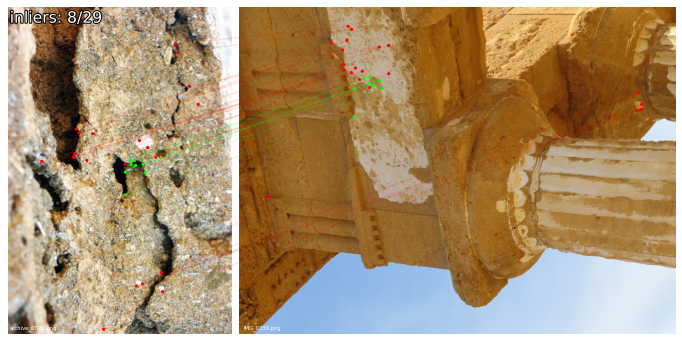

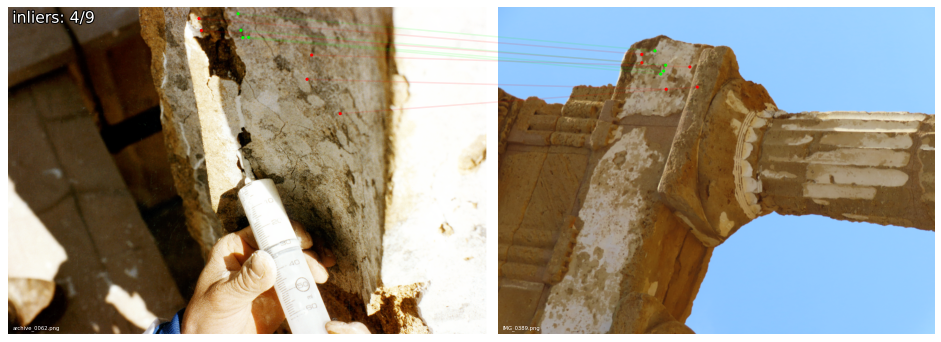